In [7]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision
import matplotlib.pyplot as plt



folder = ImageFolder('./a5_data_new/train', transform=torchvision.transforms.ToTensor())
loader = DataLoader(folder, batch_size=8, shuffle=True)

# Xexamples, Yexamples = next(iter(loader))

# for i in range(8):
#     plt.subplot(2,4,i+1)  
#     img = Xexamples[i].numpy().transpose(1, 2, 0)    
#     plt.imshow(img, interpolation='none')
#     plt.title('NV' if Yexamples[i] else 'MEL')
#     plt.xticks([])
#     plt.yticks([])
# plt.show()









AttributeError: partially initialized module 'torchvision' has no attribute 'extension' (most likely due to a circular import)

In [ ]:
## making the cnn
import torch
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm

# Check if CUDA is available, otherwise use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

## first we train the model here is the function for training it

# from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torchvision
import numpy

import torch.nn as nn

## lended from lectures evaluates score
def predict_and_evaluate(model, data):

    all_gold = []
    all_pred = []

    for Xbatch, Ybatch in data:
        # move the data to the GPU
        Xbatch = Xbatch.to(device)
        Ybatch = Ybatch.to(device)
        outputs = model(Xbatch)
        predictions = outputs.argmax(dim=1)
        # move the data back to CPU
        # and convert to numpy
        all_gold.extend(Ybatch.cpu().numpy())
        all_pred.extend(predictions.cpu().numpy())



    return accuracy_score(all_gold, all_pred) 

def train_classifier(model, train_data, val_data, hyperparams):

    # Deals with model updates. Adam is more effective than SGD.
    optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams['lr'])    
    
    # Cross-entropy loss because we have 10 classes.
    # Note that the softmax is "baked into" this loss, so we should not
    # use a softmax at the end.
    loss_func = torch.nn.CrossEntropyLoss()
      
    # Some statistics.
    acc_history = []

    for epoch in range(hyperparams['n_epochs']):

        # Set the model in training mode, enabling dropout if we use that.
        model.train()
        
        loss_sum = 0

        # For each batch
        for Xbatch, Ybatch in tqdm(train_data):

            # move the data to the GPU
            Xbatch = Xbatch.to(device)
            Ybatch = Ybatch.to(device)

            # Apply the model. We don't know at this point what the model is.
            # The output should be of the shape (batch_size, 10).
            outputs = model(Xbatch)

            # Apply the cross-entropy loss.
            loss = loss_func(outputs, Ybatch)

            # Update the model.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_sum += loss.item()

        # Set the model in evaluation mode. Disables dropout if present.
        model.eval()
        with torch.no_grad():
            # Compute the accuracy on the validation data.
            val_acc = predict_and_evaluate(model, val_data)
                
        mean_loss = loss_sum / len(train_data)

        acc_history.append(val_acc)
        
        print(f'Epoch {epoch+1}: loss = {mean_loss:.4f}, val acc = {val_acc:.4f}')
    
    return acc_history

def train_model(model, trainFolder, testFolder,  epochs=10, batch_size=32, learning_rate=0.001):
  
    train_loader = DataLoader(trainFolder, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(testFolder, batch_size=batch_size, shuffle=False)

    # Define hyperparameters
    hyperparams = {
        'n_epochs': epochs,
        'lr': learning_rate
    }

    # Train the model
    acc_history = train_classifier(model, train_loader, val_loader, hyperparams)

    return acc_history
                

## Import train and test sets from the images. The Y values are the names of the folders
Xtrain = []
Ytrain = []
Xval = []
Yval = []

trainFolder = torchvision.datasets.ImageFolder('./a5_data_new/train', transform=torchvision.transforms.ToTensor())
valFolder = torchvision.datasets.ImageFolder('./a5_data_new/val', transform=torchvision.transforms.ToTensor())



# linear_model = nn.Linear(in_features=n_input_features, out_features=1)
# acc_history = train_model(linear_model, Xtrain, Ytrain, Xval, Yval, epochs=10, batch_size=32, learning_rate=0.001)


# Define the PyTorch model
cnn_model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=5),  # Adjusted input channels to 3 for RGB images
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(16 * 29 * 29, 50),  # Adjusted input size based on image dimensions after convolutions
    nn.ReLU(),
    nn.Linear(50, 10),
).to(device)



# Set hyperparameters for grid search
grid_params = {
    'batch_size': [ 32, 64],
    'learning_rate': [0.001, 0.01]
}

# Perform grid search manually
best_score = 0
best_params = {}

for batch_size in grid_params['batch_size']:
    for learning_rate in grid_params['learning_rate']:
        print(f"Training with batch_size={batch_size}, learning_rate={learning_rate}")
        acc_history = train_model(cnn_model, trainFolder, valFolder, epochs=5 , batch_size=batch_size, learning_rate=learning_rate)
        val_acc = acc_history[-1]  # Get the validation accuracy of the last epoch
        if val_acc > best_score:
            best_score = val_acc
            best_params = {'batch_size': batch_size, 'learning_rate': learning_rate}

print("Best parameters found: ", best_params)
print("Best validation accuracy: ", best_score)

# Train the model with the best parameters
best_batch_size = best_params['batch_size']
best_learning_rate = best_params['learning_rate']
acc_history = train_model(cnn_model, trainFolder, valFolder, epochs=50, batch_size=best_batch_size, learning_rate=best_learning_rate)



Training with batch_size=32, learning_rate=0.001


100%|██████████| 201/201 [00:09<00:00, 21.72it/s]


Epoch 1: loss = 0.5631, val acc = 0.7420


100%|██████████| 201/201 [00:10<00:00, 20.00it/s]


Epoch 2: loss = 0.4709, val acc = 0.7492


100%|██████████| 201/201 [00:09<00:00, 20.36it/s]


Epoch 3: loss = 0.4535, val acc = 0.7851


100%|██████████| 201/201 [00:09<00:00, 21.56it/s]


Epoch 4: loss = 0.4274, val acc = 0.7692


100%|██████████| 201/201 [00:09<00:00, 21.33it/s]


Epoch 5: loss = 0.4582, val acc = 0.7508
Training with batch_size=32, learning_rate=0.01


100%|██████████| 201/201 [00:09<00:00, 21.09it/s]


Epoch 1: loss = 0.7435, val acc = 0.7053


100%|██████████| 201/201 [00:09<00:00, 21.07it/s]


Epoch 2: loss = 0.5255, val acc = 0.6613


100%|██████████| 201/201 [00:09<00:00, 21.25it/s]


Epoch 3: loss = 0.5002, val acc = 0.7364


100%|██████████| 201/201 [00:09<00:00, 21.03it/s]


Epoch 4: loss = 0.5213, val acc = 0.6981


100%|██████████| 201/201 [00:09<00:00, 21.58it/s]


Epoch 5: loss = 0.4966, val acc = 0.6877
Training with batch_size=64, learning_rate=0.001


100%|██████████| 101/101 [00:08<00:00, 11.50it/s]


Epoch 1: loss = 0.4621, val acc = 0.7308


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 2: loss = 0.4437, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 3: loss = 0.4342, val acc = 0.7604


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 4: loss = 0.4310, val acc = 0.7588


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 5: loss = 0.4220, val acc = 0.7548
Training with batch_size=64, learning_rate=0.01


100%|██████████| 101/101 [00:09<00:00, 10.85it/s]


Epoch 1: loss = 0.5698, val acc = 0.7029


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 2: loss = 0.5558, val acc = 0.6973


100%|██████████| 101/101 [00:09<00:00, 11.02it/s]


Epoch 3: loss = 0.5462, val acc = 0.7045


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 4: loss = 0.5573, val acc = 0.6997


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 5: loss = 0.5451, val acc = 0.7013
Best parameters found:  {'batch_size': 64, 'learning_rate': 0.001}
Best validation accuracy:  0.7547923322683706


100%|██████████| 101/101 [00:09<00:00, 10.92it/s]


Epoch 1: loss = 0.5322, val acc = 0.7037


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 2: loss = 0.5267, val acc = 0.7069


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 3: loss = 0.5202, val acc = 0.7101


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 4: loss = 0.5120, val acc = 0.7244


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 5: loss = 0.5086, val acc = 0.7276


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 6: loss = 0.4963, val acc = 0.7324


100%|██████████| 101/101 [00:09<00:00, 11.04it/s]


Epoch 7: loss = 0.4888, val acc = 0.7348


100%|██████████| 101/101 [00:08<00:00, 11.44it/s]


Epoch 8: loss = 0.4775, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.42it/s]


Epoch 9: loss = 0.4631, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.40it/s]


Epoch 10: loss = 0.4552, val acc = 0.7580


100%|██████████| 101/101 [00:08<00:00, 11.46it/s]


Epoch 11: loss = 0.4356, val acc = 0.7588


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 12: loss = 0.4137, val acc = 0.7596


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 13: loss = 0.3905, val acc = 0.7604


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 14: loss = 0.3786, val acc = 0.7620


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 15: loss = 0.3585, val acc = 0.7628


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 16: loss = 0.3320, val acc = 0.7564


100%|██████████| 101/101 [00:09<00:00, 10.90it/s]


Epoch 17: loss = 0.3088, val acc = 0.7588


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 18: loss = 0.2947, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.44it/s]


Epoch 19: loss = 0.2665, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 20: loss = 0.2471, val acc = 0.7596


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 21: loss = 0.2334, val acc = 0.7548


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 22: loss = 0.2145, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 10.97it/s]


Epoch 23: loss = 0.1992, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 11.02it/s]


Epoch 24: loss = 0.1899, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 10.84it/s]


Epoch 25: loss = 0.1737, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 26: loss = 0.1579, val acc = 0.7412


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 27: loss = 0.1487, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 28: loss = 0.1379, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 29: loss = 0.1269, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 30: loss = 0.1149, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 31: loss = 0.1081, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 32: loss = 0.0966, val acc = 0.7404


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 33: loss = 0.1168, val acc = 0.7580


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 34: loss = 0.0846, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.46it/s]


Epoch 35: loss = 0.0726, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.58it/s]


Epoch 36: loss = 0.0618, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.43it/s]


Epoch 37: loss = 0.0530, val acc = 0.7596


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 38: loss = 0.0502, val acc = 0.7556


100%|██████████| 101/101 [00:08<00:00, 11.51it/s]


Epoch 39: loss = 0.0415, val acc = 0.7572


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 40: loss = 0.0355, val acc = 0.7580


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 41: loss = 0.0323, val acc = 0.7596


100%|██████████| 101/101 [00:09<00:00, 10.81it/s]


Epoch 42: loss = 0.0319, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.57it/s]


Epoch 43: loss = 0.0328, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 44: loss = 0.0292, val acc = 0.7644


100%|██████████| 101/101 [00:08<00:00, 11.44it/s]


Epoch 45: loss = 0.0218, val acc = 0.7572


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 46: loss = 0.0176, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 47: loss = 0.0169, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 48: loss = 0.0142, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 49: loss = 0.0130, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.06it/s]


Epoch 50: loss = 0.0103, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 51: loss = 0.0090, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 10.79it/s]


Epoch 52: loss = 0.0094, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 53: loss = 0.0075, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 10.76it/s]


Epoch 54: loss = 0.0067, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.61it/s]


Epoch 55: loss = 0.0064, val acc = 0.7460


100%|██████████| 101/101 [00:07<00:00, 12.84it/s]


Epoch 56: loss = 0.0056, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 57: loss = 0.0049, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 10.69it/s]


Epoch 58: loss = 0.0046, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 59: loss = 0.0043, val acc = 0.7404


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 60: loss = 0.0674, val acc = 0.7340


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 61: loss = 0.0613, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 62: loss = 0.0175, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 63: loss = 0.0137, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 64: loss = 0.0075, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 65: loss = 0.0067, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 66: loss = 0.0043, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 67: loss = 0.0042, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.55it/s]


Epoch 68: loss = 0.0038, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 69: loss = 0.0040, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 10.84it/s]


Epoch 70: loss = 0.0031, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.06it/s]


Epoch 71: loss = 0.0043, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.49it/s]


Epoch 72: loss = 0.0036, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 73: loss = 0.0031, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.41it/s]


Epoch 74: loss = 0.0024, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.51it/s]


Epoch 75: loss = 0.0031, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 76: loss = 0.0029, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 77: loss = 0.0026, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 10.34it/s]


Epoch 78: loss = 0.0021, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.48it/s]


Epoch 79: loss = 0.0021, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.06it/s]


Epoch 80: loss = 0.0019, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 81: loss = 0.0021, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.06it/s]


Epoch 82: loss = 0.0023, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 10.91it/s]


Epoch 83: loss = 0.0300, val acc = 0.7580


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 84: loss = 0.0330, val acc = 0.7372


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 85: loss = 0.0345, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.00it/s]


Epoch 86: loss = 0.0116, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 87: loss = 0.0049, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 88: loss = 0.0028, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 89: loss = 0.0023, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 90: loss = 0.0022, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 91: loss = 0.0020, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 92: loss = 0.0018, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.52it/s]


Epoch 93: loss = 0.0019, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 94: loss = 0.0016, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 95: loss = 0.0016, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.06it/s]


Epoch 96: loss = 0.0020, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 97: loss = 0.0019, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 98: loss = 0.0014, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 10.93it/s]


Epoch 99: loss = 0.0015, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 12.62it/s]


Epoch 100: loss = 0.0014, val acc = 0.7444


100%|██████████| 101/101 [00:07<00:00, 12.94it/s]


Epoch 101: loss = 0.0014, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 102: loss = 0.0014, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.40it/s]


Epoch 103: loss = 0.0018, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 104: loss = 0.0012, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 105: loss = 0.0032, val acc = 0.7396


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 106: loss = 0.0600, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 107: loss = 0.0197, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.47it/s]


Epoch 108: loss = 0.0140, val acc = 0.7380


100%|██████████| 101/101 [00:09<00:00, 10.95it/s]


Epoch 109: loss = 0.0219, val acc = 0.7556


100%|██████████| 101/101 [00:09<00:00, 10.87it/s]


Epoch 110: loss = 0.0100, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 10.94it/s]


Epoch 111: loss = 0.0026, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 10.98it/s]


Epoch 112: loss = 0.0020, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.04it/s]


Epoch 113: loss = 0.0017, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 114: loss = 0.0016, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 115: loss = 0.0015, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 116: loss = 0.0014, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.62it/s]


Epoch 117: loss = 0.0027, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 10.64it/s]


Epoch 118: loss = 0.0015, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.03it/s]


Epoch 119: loss = 0.0012, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 120: loss = 0.0085, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 121: loss = 0.0053, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 122: loss = 0.0053, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 123: loss = 0.0025, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 124: loss = 0.0015, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.42it/s]


Epoch 125: loss = 0.0011, val acc = 0.7412


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 126: loss = 0.0010, val acc = 0.7396


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 127: loss = 0.0010, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 128: loss = 0.0011, val acc = 0.7404


100%|██████████| 101/101 [00:09<00:00, 10.88it/s]


Epoch 129: loss = 0.0011, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.63it/s]


Epoch 130: loss = 0.0008, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 131: loss = 0.0011, val acc = 0.7404


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 132: loss = 0.0009, val acc = 0.7404


100%|██████████| 101/101 [00:07<00:00, 12.68it/s]


Epoch 133: loss = 0.0006, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 134: loss = 0.0011, val acc = 0.7396


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 135: loss = 0.0039, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 136: loss = 0.0065, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 137: loss = 0.0018, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 138: loss = 0.0467, val acc = 0.7380


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 139: loss = 0.0182, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.49it/s]


Epoch 140: loss = 0.0120, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 141: loss = 0.0074, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 142: loss = 0.0024, val acc = 0.7572


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 143: loss = 0.0114, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.01it/s]


Epoch 144: loss = 0.0035, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 145: loss = 0.0022, val acc = 0.7380


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 146: loss = 0.0029, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 12.45it/s]


Epoch 147: loss = 0.0009, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 148: loss = 0.0012, val acc = 0.7396


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 149: loss = 0.0009, val acc = 0.7404


100%|██████████| 101/101 [00:09<00:00, 11.01it/s]


Epoch 150: loss = 0.0012, val acc = 0.7556


100%|██████████| 101/101 [00:07<00:00, 12.80it/s]


Epoch 151: loss = 0.0012, val acc = 0.7404


100%|██████████| 101/101 [00:07<00:00, 12.79it/s]


Epoch 152: loss = 0.0009, val acc = 0.7396


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 153: loss = 0.0112, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.13it/s]


Epoch 154: loss = 0.0017, val acc = 0.7460


100%|██████████| 101/101 [00:07<00:00, 12.91it/s]


Epoch 155: loss = 0.0011, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 156: loss = 0.0006, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 157: loss = 0.0009, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 10.89it/s]


Epoch 158: loss = 0.0005, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 159: loss = 0.0003, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 10.94it/s]


Epoch 160: loss = 0.0004, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 161: loss = 0.0003, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 162: loss = 0.0016, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 163: loss = 0.0037, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 164: loss = 0.0038, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 10.98it/s]


Epoch 165: loss = 0.0018, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 10.99it/s]


Epoch 166: loss = 0.0004, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 167: loss = 0.0002, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.05it/s]


Epoch 168: loss = 0.0001, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.04it/s]


Epoch 169: loss = 0.0002, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 10.72it/s]


Epoch 170: loss = 0.0001, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 171: loss = 0.0001, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.49it/s]


Epoch 172: loss = 0.0001, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.02it/s]


Epoch 173: loss = 0.0001, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.02it/s]


Epoch 174: loss = 0.0001, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 175: loss = 0.0001, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 10.68it/s]


Epoch 176: loss = 0.0001, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 177: loss = 0.0001, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 178: loss = 0.0001, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.43it/s]


Epoch 179: loss = 0.0001, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.51it/s]


Epoch 180: loss = 0.0001, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 181: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.07it/s]


Epoch 182: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 183: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 184: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 185: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.02it/s]


Epoch 186: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 187: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.06it/s]


Epoch 188: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.05it/s]


Epoch 189: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 190: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.42it/s]


Epoch 191: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 192: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 10.97it/s]


Epoch 193: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 194: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 195: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 196: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:07<00:00, 12.69it/s]


Epoch 197: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 198: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 10.85it/s]


Epoch 199: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 10.98it/s]


Epoch 200: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 201: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 202: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 203: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 204: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 10.65it/s]


Epoch 205: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 10.88it/s]


Epoch 206: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 207: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 208: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 209: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.46it/s]


Epoch 210: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.55it/s]


Epoch 211: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 212: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 213: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.43it/s]


Epoch 214: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.06it/s]


Epoch 215: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 10.98it/s]


Epoch 216: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 10.86it/s]


Epoch 217: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 10.95it/s]


Epoch 218: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.06it/s]


Epoch 219: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 220: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 10.99it/s]


Epoch 221: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 10.91it/s]


Epoch 222: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.02it/s]


Epoch 223: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 224: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 12.48it/s]


Epoch 225: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 10.92it/s]


Epoch 226: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 227: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.40it/s]


Epoch 228: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 10.79it/s]


Epoch 229: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:07<00:00, 12.93it/s]


Epoch 230: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 231: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.60it/s]


Epoch 232: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 233: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 10.72it/s]


Epoch 234: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.39it/s]


Epoch 235: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 236: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 237: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 238: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 239: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.41it/s]


Epoch 240: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 241: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 242: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 243: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 244: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.41it/s]


Epoch 245: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 246: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 247: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.46it/s]


Epoch 248: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 249: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 250: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 251: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 252: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.52it/s]


Epoch 253: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.52it/s]


Epoch 254: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 255: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 256: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.01it/s]


Epoch 257: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 258: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.43it/s]


Epoch 259: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 10.97it/s]


Epoch 260: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.73it/s]


Epoch 261: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 262: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 263: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.39it/s]


Epoch 264: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.45it/s]


Epoch 265: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 266: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 267: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 10.99it/s]


Epoch 268: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 269: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 270: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.55it/s]


Epoch 271: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 272: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 273: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 274: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 275: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 276: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 277: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.07it/s]


Epoch 278: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.47it/s]


Epoch 279: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 280: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 281: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.54it/s]


Epoch 282: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.04it/s]


Epoch 283: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 284: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 285: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.59it/s]


Epoch 286: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 287: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 288: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.50it/s]


Epoch 289: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 290: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 291: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 292: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 293: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 294: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 295: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 296: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 297: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.07it/s]


Epoch 298: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 299: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 300: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.41it/s]


Epoch 301: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 302: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 303: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 10.87it/s]


Epoch 304: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.06it/s]


Epoch 305: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 306: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 307: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 308: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 309: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 310: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 311: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 312: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.01it/s]


Epoch 313: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.61it/s]


Epoch 314: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 315: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 10.89it/s]


Epoch 316: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 317: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.52it/s]


Epoch 318: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 319: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.43it/s]


Epoch 320: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 321: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.04it/s]


Epoch 322: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 323: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.40it/s]


Epoch 324: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 325: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 326: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 327: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 328: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 329: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 330: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 10.92it/s]


Epoch 331: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.04it/s]


Epoch 332: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 10.86it/s]


Epoch 333: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.41it/s]


Epoch 334: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 335: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 336: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 337: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.39it/s]


Epoch 338: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 339: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.01it/s]


Epoch 340: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 10.96it/s]


Epoch 341: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.42it/s]


Epoch 342: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 343: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 344: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 345: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 346: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.69it/s]


Epoch 347: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 10.88it/s]


Epoch 348: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 349: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.44it/s]


Epoch 350: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 351: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.75it/s]


Epoch 352: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 353: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.52it/s]


Epoch 354: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 355: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 356: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.58it/s]


Epoch 357: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 358: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.40it/s]


Epoch 359: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 360: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 361: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.04it/s]


Epoch 362: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.42it/s]


Epoch 363: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 364: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 365: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 366: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.56it/s]


Epoch 367: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.46it/s]


Epoch 368: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 369: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 370: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.58it/s]


Epoch 371: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 372: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.44it/s]


Epoch 373: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.81it/s]


Epoch 374: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 10.95it/s]


Epoch 375: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 376: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 377: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 378: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 379: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.40it/s]


Epoch 380: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 381: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 382: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 383: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 384: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 385: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 386: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.61it/s]


Epoch 387: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 388: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 389: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 390: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 391: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 10.95it/s]


Epoch 392: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 393: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 394: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.07it/s]


Epoch 395: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.43it/s]


Epoch 396: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 397: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.03it/s]


Epoch 398: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.52it/s]


Epoch 399: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 400: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 10.93it/s]


Epoch 401: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.50it/s]


Epoch 402: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 403: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 404: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.46it/s]


Epoch 405: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 406: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 407: loss = 0.2385, val acc = 0.7380


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 408: loss = 0.0709, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 409: loss = 0.0059, val acc = 0.7596


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 410: loss = 0.0026, val acc = 0.7556


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 411: loss = 0.0011, val acc = 0.7548


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 412: loss = 0.0006, val acc = 0.7580


100%|██████████| 101/101 [00:08<00:00, 11.42it/s]


Epoch 413: loss = 0.0005, val acc = 0.7604


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 414: loss = 0.0005, val acc = 0.7596


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 415: loss = 0.0004, val acc = 0.7628


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 416: loss = 0.0003, val acc = 0.7612


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 417: loss = 0.0003, val acc = 0.7612


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 418: loss = 0.0003, val acc = 0.7612


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 419: loss = 0.0002, val acc = 0.7564


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 420: loss = 0.0002, val acc = 0.7612


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 421: loss = 0.0002, val acc = 0.7572


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 422: loss = 0.0002, val acc = 0.7620


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 423: loss = 0.0002, val acc = 0.7588


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 424: loss = 0.0002, val acc = 0.7620


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 425: loss = 0.0001, val acc = 0.7580


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 426: loss = 0.0001, val acc = 0.7588


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 427: loss = 0.0001, val acc = 0.7596


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 428: loss = 0.0001, val acc = 0.7564


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 429: loss = 0.0001, val acc = 0.7580


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 430: loss = 0.0001, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 11.01it/s]


Epoch 431: loss = 0.0001, val acc = 0.7564


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 432: loss = 0.0001, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 10.75it/s]


Epoch 433: loss = 0.0001, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 434: loss = 0.0001, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 11.00it/s]


Epoch 435: loss = 0.0001, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 11.01it/s]


Epoch 436: loss = 0.0001, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 437: loss = 0.0001, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 438: loss = 0.0001, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.01it/s]


Epoch 439: loss = 0.0001, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 440: loss = 0.0001, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.49it/s]


Epoch 441: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 10.94it/s]


Epoch 442: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 443: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 444: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 445: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 446: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 447: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 11.06it/s]


Epoch 448: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 449: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 450: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 451: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 452: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 453: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 454: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 455: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.47it/s]


Epoch 456: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.48it/s]


Epoch 457: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 458: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 10.84it/s]


Epoch 459: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 460: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 461: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.00it/s]


Epoch 462: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.55it/s]


Epoch 463: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.45it/s]


Epoch 464: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 465: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 466: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.13it/s]


Epoch 467: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.61it/s]


Epoch 468: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 469: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 470: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 471: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.02it/s]


Epoch 472: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 10.76it/s]


Epoch 473: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 10.91it/s]


Epoch 474: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 475: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.41it/s]


Epoch 476: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 477: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.58it/s]


Epoch 478: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 479: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 10.92it/s]


Epoch 480: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.07it/s]


Epoch 481: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 482: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 483: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 484: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 11.13it/s]


Epoch 485: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 486: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 487: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.61it/s]


Epoch 488: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 489: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 490: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 10.96it/s]


Epoch 491: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 492: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 493: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 494: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 495: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 496: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 10.97it/s]


Epoch 497: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 498: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.52it/s]


Epoch 499: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 500: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 501: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 10.87it/s]


Epoch 502: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.43it/s]


Epoch 503: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 504: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 505: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 506: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 507: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 508: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 509: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 510: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 511: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.54it/s]


Epoch 512: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 513: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.00it/s]


Epoch 514: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.02it/s]


Epoch 515: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 516: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 517: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.46it/s]


Epoch 518: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 10.96it/s]


Epoch 519: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 520: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.42it/s]


Epoch 521: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 522: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 523: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 524: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.02it/s]


Epoch 525: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 10.99it/s]


Epoch 526: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 527: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 528: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 529: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 530: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 10.90it/s]


Epoch 531: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 532: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 533: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:09<00:00, 11.02it/s]


Epoch 534: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 535: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 536: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 537: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 538: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 539: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 540: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 541: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.13it/s]


Epoch 542: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 543: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 544: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 545: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.47it/s]


Epoch 546: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 547: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 548: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 10.98it/s]


Epoch 549: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 10.99it/s]


Epoch 550: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 551: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 552: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 553: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 554: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 555: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 556: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 557: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 558: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.51it/s]


Epoch 559: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.58it/s]


Epoch 560: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 561: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 562: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 563: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 564: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 565: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 566: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 567: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 568: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 569: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.42it/s]


Epoch 570: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 571: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 572: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 573: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 10.96it/s]


Epoch 574: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 10.84it/s]


Epoch 575: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 576: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 577: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.07it/s]


Epoch 578: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.63it/s]


Epoch 579: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 580: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.41it/s]


Epoch 581: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 582: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 583: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.02it/s]


Epoch 584: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 585: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 586: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 587: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 588: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 589: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 590: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 591: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 10.99it/s]


Epoch 592: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 593: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 594: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 595: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 596: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.55it/s]


Epoch 597: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 10.97it/s]


Epoch 598: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.04it/s]


Epoch 599: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.06it/s]


Epoch 600: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.53it/s]


Epoch 601: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 602: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 603: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.43it/s]


Epoch 604: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 605: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 606: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 10.94it/s]


Epoch 607: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 608: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 10.98it/s]


Epoch 609: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.59it/s]


Epoch 610: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 611: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 612: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 613: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 614: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 615: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 616: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 617: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 618: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 619: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 620: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.84it/s]


Epoch 621: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 622: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 623: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.04it/s]


Epoch 624: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 625: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 626: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 627: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 628: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 629: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 630: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.13it/s]


Epoch 631: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 632: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.42it/s]


Epoch 633: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 634: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 635: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.00it/s]


Epoch 636: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 637: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.03it/s]


Epoch 638: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.44it/s]


Epoch 639: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 640: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.39it/s]


Epoch 641: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 642: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.62it/s]


Epoch 643: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 644: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 645: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 10.93it/s]


Epoch 646: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.43it/s]


Epoch 647: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.61it/s]


Epoch 648: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 649: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 650: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 10.91it/s]


Epoch 651: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 652: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 653: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 654: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 655: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 656: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 657: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 11.02it/s]


Epoch 658: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 659: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.22it/s]


Epoch 660: loss = 0.1660, val acc = 0.7324


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 661: loss = 0.0437, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 662: loss = 0.0227, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 663: loss = 0.0036, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 664: loss = 0.0009, val acc = 0.7356


100%|██████████| 101/101 [00:09<00:00, 11.04it/s]


Epoch 665: loss = 0.0003, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 666: loss = 0.0011, val acc = 0.7340


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 667: loss = 0.0013, val acc = 0.7372


100%|██████████| 101/101 [00:09<00:00, 10.78it/s]


Epoch 668: loss = 0.0001, val acc = 0.7324


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 669: loss = 0.0001, val acc = 0.7332


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 670: loss = 0.0001, val acc = 0.7332


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 671: loss = 0.0001, val acc = 0.7332


100%|██████████| 101/101 [00:08<00:00, 11.45it/s]


Epoch 672: loss = 0.0001, val acc = 0.7324


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 673: loss = 0.0000, val acc = 0.7316


100%|██████████| 101/101 [00:08<00:00, 11.66it/s]


Epoch 674: loss = 0.0000, val acc = 0.7332


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 675: loss = 0.0000, val acc = 0.7340


100%|██████████| 101/101 [00:08<00:00, 11.47it/s]


Epoch 676: loss = 0.0000, val acc = 0.7348


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 677: loss = 0.0000, val acc = 0.7340


100%|██████████| 101/101 [00:08<00:00, 11.42it/s]


Epoch 678: loss = 0.0000, val acc = 0.7340


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 679: loss = 0.0000, val acc = 0.7332


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 680: loss = 0.0000, val acc = 0.7332


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 681: loss = 0.0000, val acc = 0.7332


100%|██████████| 101/101 [00:08<00:00, 11.42it/s]


Epoch 682: loss = 0.0000, val acc = 0.7332


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 683: loss = 0.0000, val acc = 0.7332


100%|██████████| 101/101 [00:08<00:00, 11.52it/s]


Epoch 684: loss = 0.0000, val acc = 0.7332


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 685: loss = 0.0000, val acc = 0.7332


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 686: loss = 0.0000, val acc = 0.7324


100%|██████████| 101/101 [00:09<00:00, 11.05it/s]


Epoch 687: loss = 0.0000, val acc = 0.7324


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 688: loss = 0.0000, val acc = 0.7324


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 689: loss = 0.0000, val acc = 0.7324


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 690: loss = 0.0000, val acc = 0.7332


100%|██████████| 101/101 [00:08<00:00, 11.43it/s]


Epoch 691: loss = 0.0000, val acc = 0.7332


100%|██████████| 101/101 [00:09<00:00, 10.83it/s]


Epoch 692: loss = 0.0000, val acc = 0.7324


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 693: loss = 0.0000, val acc = 0.7324


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 694: loss = 0.0000, val acc = 0.7316


100%|██████████| 101/101 [00:08<00:00, 11.50it/s]


Epoch 695: loss = 0.0000, val acc = 0.7324


100%|██████████| 101/101 [00:08<00:00, 11.52it/s]


Epoch 696: loss = 0.0000, val acc = 0.7324


100%|██████████| 101/101 [00:09<00:00, 11.01it/s]


Epoch 697: loss = 0.0000, val acc = 0.7324


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 698: loss = 0.0000, val acc = 0.7324


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 699: loss = 0.0000, val acc = 0.7324


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 700: loss = 0.0000, val acc = 0.7324


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 701: loss = 0.0000, val acc = 0.7324


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 702: loss = 0.0000, val acc = 0.7340


100%|██████████| 101/101 [00:08<00:00, 11.39it/s]


Epoch 703: loss = 0.0000, val acc = 0.7332


100%|██████████| 101/101 [00:08<00:00, 11.74it/s]


Epoch 704: loss = 0.0000, val acc = 0.7340


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 705: loss = 0.0000, val acc = 0.7348


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 706: loss = 0.0000, val acc = 0.7356


100%|██████████| 101/101 [00:08<00:00, 11.45it/s]


Epoch 707: loss = 0.0000, val acc = 0.7348


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 708: loss = 0.0000, val acc = 0.7356


100%|██████████| 101/101 [00:09<00:00, 10.66it/s]


Epoch 709: loss = 0.0000, val acc = 0.7356


100%|██████████| 101/101 [00:08<00:00, 11.43it/s]


Epoch 710: loss = 0.0000, val acc = 0.7356


100%|██████████| 101/101 [00:08<00:00, 11.39it/s]


Epoch 711: loss = 0.0000, val acc = 0.7356


100%|██████████| 101/101 [00:08<00:00, 11.48it/s]


Epoch 712: loss = 0.0000, val acc = 0.7356


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 713: loss = 0.0000, val acc = 0.7356


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 714: loss = 0.0000, val acc = 0.7356


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 715: loss = 0.0000, val acc = 0.7356


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 716: loss = 0.0000, val acc = 0.7356


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 717: loss = 0.0000, val acc = 0.7372


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 718: loss = 0.0000, val acc = 0.7372


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 719: loss = 0.0000, val acc = 0.7372


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 720: loss = 0.0000, val acc = 0.7372


100%|██████████| 101/101 [00:09<00:00, 11.04it/s]


Epoch 721: loss = 0.0000, val acc = 0.7364


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 722: loss = 0.0000, val acc = 0.7364


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 723: loss = 0.0000, val acc = 0.7364


100%|██████████| 101/101 [00:09<00:00, 10.91it/s]


Epoch 724: loss = 0.0000, val acc = 0.7372


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 725: loss = 0.0000, val acc = 0.7372


100%|██████████| 101/101 [00:08<00:00, 11.52it/s]


Epoch 726: loss = 0.0000, val acc = 0.7372


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 727: loss = 0.0000, val acc = 0.7372


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 728: loss = 0.0000, val acc = 0.7372


100%|██████████| 101/101 [00:08<00:00, 11.40it/s]


Epoch 729: loss = 0.0000, val acc = 0.7380


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 730: loss = 0.0000, val acc = 0.7380


100%|██████████| 101/101 [00:09<00:00, 11.07it/s]


Epoch 731: loss = 0.0000, val acc = 0.7372


100%|██████████| 101/101 [00:08<00:00, 11.61it/s]


Epoch 732: loss = 0.0000, val acc = 0.7372


100%|██████████| 101/101 [00:08<00:00, 11.43it/s]


Epoch 733: loss = 0.0000, val acc = 0.7372


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 734: loss = 0.0000, val acc = 0.7372


100%|██████████| 101/101 [00:09<00:00, 10.97it/s]


Epoch 735: loss = 0.0000, val acc = 0.7372


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 736: loss = 0.0000, val acc = 0.7372


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 737: loss = 0.0000, val acc = 0.7372


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 738: loss = 0.0000, val acc = 0.7372


100%|██████████| 101/101 [00:08<00:00, 11.47it/s]


Epoch 739: loss = 0.0000, val acc = 0.7372


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 740: loss = 0.0000, val acc = 0.7372


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 741: loss = 0.0000, val acc = 0.7380


100%|██████████| 101/101 [00:08<00:00, 11.42it/s]


Epoch 742: loss = 0.0000, val acc = 0.7364


100%|██████████| 101/101 [00:08<00:00, 11.42it/s]


Epoch 743: loss = 0.0000, val acc = 0.7372


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 744: loss = 0.0000, val acc = 0.7372


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 745: loss = 0.0000, val acc = 0.7372


100%|██████████| 101/101 [00:08<00:00, 11.52it/s]


Epoch 746: loss = 0.0000, val acc = 0.7372


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 747: loss = 0.0000, val acc = 0.7372


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 748: loss = 0.0000, val acc = 0.7372


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 749: loss = 0.0000, val acc = 0.7372


100%|██████████| 101/101 [00:09<00:00, 11.06it/s]


Epoch 750: loss = 0.0000, val acc = 0.7364


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 751: loss = 0.0000, val acc = 0.7372


100%|██████████| 101/101 [00:08<00:00, 11.44it/s]


Epoch 752: loss = 0.0000, val acc = 0.7364


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 753: loss = 0.0000, val acc = 0.7364


100%|██████████| 101/101 [00:08<00:00, 11.39it/s]


Epoch 754: loss = 0.0000, val acc = 0.7356


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 755: loss = 0.0000, val acc = 0.7364


100%|██████████| 101/101 [00:09<00:00, 10.99it/s]


Epoch 756: loss = 0.0000, val acc = 0.7356


100%|██████████| 101/101 [00:09<00:00, 11.13it/s]


Epoch 757: loss = 0.0000, val acc = 0.7356


100%|██████████| 101/101 [00:09<00:00, 10.81it/s]


Epoch 758: loss = 0.0000, val acc = 0.7364


100%|██████████| 101/101 [00:09<00:00, 11.07it/s]


Epoch 759: loss = 0.0000, val acc = 0.7364


100%|██████████| 101/101 [00:08<00:00, 11.48it/s]


Epoch 760: loss = 0.0000, val acc = 0.7364


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 761: loss = 0.0000, val acc = 0.7380


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 762: loss = 0.0000, val acc = 0.7380


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 763: loss = 0.0000, val acc = 0.7372


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 764: loss = 0.0000, val acc = 0.7380


100%|██████████| 101/101 [00:08<00:00, 11.72it/s]


Epoch 765: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:09<00:00, 10.85it/s]


Epoch 766: loss = 0.0000, val acc = 0.7396


100%|██████████| 101/101 [00:09<00:00, 10.93it/s]


Epoch 767: loss = 0.0000, val acc = 0.7396


100%|██████████| 101/101 [00:08<00:00, 11.44it/s]


Epoch 768: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:09<00:00, 11.04it/s]


Epoch 769: loss = 0.0000, val acc = 0.7396


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 770: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 771: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 772: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 773: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 774: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.41it/s]


Epoch 775: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 776: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 777: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 778: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 10.87it/s]


Epoch 779: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 780: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 781: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 10.81it/s]


Epoch 782: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 783: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.59it/s]


Epoch 784: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 10.99it/s]


Epoch 785: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 10.88it/s]


Epoch 786: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 787: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 788: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 789: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 790: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 791: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 792: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 793: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 794: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 795: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 796: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 797: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.59it/s]


Epoch 798: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 10.94it/s]


Epoch 799: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.07it/s]


Epoch 800: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 801: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 802: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 803: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 10.83it/s]


Epoch 804: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.40it/s]


Epoch 805: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 806: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.63it/s]


Epoch 807: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 10.92it/s]


Epoch 808: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 809: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 810: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 811: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 812: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 813: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.51it/s]


Epoch 814: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 815: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 816: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.06it/s]


Epoch 817: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.65it/s]


Epoch 818: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 819: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.50it/s]


Epoch 820: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 10.95it/s]


Epoch 821: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 822: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 823: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 824: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 825: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 826: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 827: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 828: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.39it/s]


Epoch 829: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 830: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.40it/s]


Epoch 831: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 832: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.43it/s]


Epoch 833: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 834: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 835: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 836: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 837: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 838: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 839: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.40it/s]


Epoch 840: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.46it/s]


Epoch 841: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.79it/s]


Epoch 842: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 10.96it/s]


Epoch 843: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 844: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 845: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 10.99it/s]


Epoch 846: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 847: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 848: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 849: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.04it/s]


Epoch 850: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.22it/s]


Epoch 851: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.47it/s]


Epoch 852: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 853: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 854: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 855: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 856: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 857: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 858: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 859: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 860: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 861: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 862: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.05it/s]


Epoch 863: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.57it/s]


Epoch 864: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 865: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 10.96it/s]


Epoch 866: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 10.98it/s]


Epoch 867: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 868: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.48it/s]


Epoch 869: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.59it/s]


Epoch 870: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 871: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 872: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 873: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.00it/s]


Epoch 874: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.44it/s]


Epoch 875: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.53it/s]


Epoch 876: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 877: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.40it/s]


Epoch 878: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 10.93it/s]


Epoch 879: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 880: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 881: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 882: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 883: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 884: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 885: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.80it/s]


Epoch 886: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 887: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 888: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.13it/s]


Epoch 889: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 890: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.58it/s]


Epoch 891: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 892: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 893: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 894: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 895: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 10.62it/s]


Epoch 896: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 897: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.50it/s]


Epoch 898: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 899: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 900: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 901: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.06it/s]


Epoch 902: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 903: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 904: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 905: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 906: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.05it/s]


Epoch 907: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 908: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 909: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 910: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.13it/s]


Epoch 911: loss = 0.2455, val acc = 0.7396


100%|██████████| 101/101 [00:09<00:00, 11.07it/s]


Epoch 912: loss = 0.0116, val acc = 0.7308


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 913: loss = 0.0016, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 914: loss = 0.0085, val acc = 0.7308


100%|██████████| 101/101 [00:08<00:00, 11.51it/s]


Epoch 915: loss = 0.0011, val acc = 0.7340


100%|██████████| 101/101 [00:08<00:00, 11.54it/s]


Epoch 916: loss = 0.0005, val acc = 0.7372


100%|██████████| 101/101 [00:08<00:00, 11.40it/s]


Epoch 917: loss = 0.0012, val acc = 0.7364


100%|██████████| 101/101 [00:08<00:00, 12.27it/s]


Epoch 918: loss = 0.0002, val acc = 0.7348


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 919: loss = 0.0002, val acc = 0.7364


100%|██████████| 101/101 [00:08<00:00, 11.57it/s]


Epoch 920: loss = 0.0002, val acc = 0.7372


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 921: loss = 0.0001, val acc = 0.7372


100%|██████████| 101/101 [00:08<00:00, 11.52it/s]


Epoch 922: loss = 0.0001, val acc = 0.7380


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 923: loss = 0.0001, val acc = 0.7388


100%|██████████| 101/101 [00:08<00:00, 11.49it/s]


Epoch 924: loss = 0.0001, val acc = 0.7388


100%|██████████| 101/101 [00:09<00:00, 10.63it/s]


Epoch 925: loss = 0.0001, val acc = 0.7404


100%|██████████| 101/101 [00:08<00:00, 11.39it/s]


Epoch 926: loss = 0.0001, val acc = 0.7404


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 927: loss = 0.0001, val acc = 0.7404


100%|██████████| 101/101 [00:08<00:00, 11.42it/s]


Epoch 928: loss = 0.0001, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 929: loss = 0.0001, val acc = 0.7404


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 930: loss = 0.0001, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.63it/s]


Epoch 931: loss = 0.0001, val acc = 0.7412


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 932: loss = 0.0001, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 933: loss = 0.0001, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 934: loss = 0.0001, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 935: loss = 0.0001, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 936: loss = 0.0001, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 937: loss = 0.0001, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 938: loss = 0.0001, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 939: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 940: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 941: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.02it/s]


Epoch 942: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.05it/s]


Epoch 943: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 944: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 945: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 10.97it/s]


Epoch 946: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 947: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.47it/s]


Epoch 948: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 949: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.39it/s]


Epoch 950: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 951: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 952: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 953: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 10.25it/s]


Epoch 954: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.42it/s]


Epoch 955: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 10.96it/s]


Epoch 956: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 957: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 958: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 959: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 960: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 961: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.40it/s]


Epoch 962: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 963: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 964: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.04it/s]


Epoch 965: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 966: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 967: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 968: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 969: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 10.96it/s]


Epoch 970: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 971: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.41it/s]


Epoch 972: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 973: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 974: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.07it/s]


Epoch 975: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.46it/s]


Epoch 976: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 977: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 978: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 979: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 980: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 981: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 982: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 10.79it/s]


Epoch 983: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.22it/s]


Epoch 984: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 985: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 986: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 987: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 988: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.48it/s]


Epoch 989: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 990: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 991: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 10.33it/s]


Epoch 992: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 993: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 994: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 995: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 996: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.07it/s]


Epoch 997: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 998: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 999: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 1000: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.05it/s]


Epoch 1001: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 1002: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 1003: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 1004: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 1005: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 1006: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.46it/s]


Epoch 1007: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 1008: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 1009: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.43it/s]


Epoch 1010: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 10.95it/s]


Epoch 1011: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.41it/s]


Epoch 1012: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.41it/s]


Epoch 1013: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 1014: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 1015: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.62it/s]


Epoch 1016: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 1017: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 10.89it/s]


Epoch 1018: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.47it/s]


Epoch 1019: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 1020: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.63it/s]


Epoch 1021: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 1022: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 1023: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.48it/s]


Epoch 1024: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 1025: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 1026: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 1027: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 10.99it/s]


Epoch 1028: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.49it/s]


Epoch 1029: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 1030: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 1031: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 1032: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.53it/s]


Epoch 1033: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.41it/s]


Epoch 1034: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 10.85it/s]


Epoch 1035: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 1036: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.47it/s]


Epoch 1037: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 1038: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.41it/s]


Epoch 1039: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.03it/s]


Epoch 1040: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 10.73it/s]


Epoch 1041: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 1042: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 1043: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.03it/s]


Epoch 1044: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.61it/s]


Epoch 1045: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.59it/s]


Epoch 1046: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.53it/s]


Epoch 1047: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 1048: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 1049: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 1050: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 1051: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 1052: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 1053: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 1054: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 1055: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 1056: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 1057: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 1058: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 10.94it/s]


Epoch 1059: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 1060: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 1061: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 1062: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.03it/s]


Epoch 1063: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 1064: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 1065: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.00it/s]


Epoch 1066: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 1067: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 1068: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 1069: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 10.86it/s]


Epoch 1070: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 1071: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 1072: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 1073: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 1074: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.48it/s]


Epoch 1075: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.03it/s]


Epoch 1076: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.22it/s]


Epoch 1077: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 1078: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 1079: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 1080: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.41it/s]


Epoch 1081: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 1082: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 1083: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 1084: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 1085: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 1086: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 1087: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 1088: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 1089: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.13it/s]


Epoch 1090: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 1091: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 1092: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 1093: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 1094: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 1095: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 1096: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 1097: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.13it/s]


Epoch 1098: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 10.87it/s]


Epoch 1099: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 1100: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 1101: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 10.91it/s]


Epoch 1102: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 1103: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 1104: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 1105: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 1106: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 1107: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 1108: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 1109: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 1110: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 1111: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 1112: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 1113: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.55it/s]


Epoch 1114: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 1115: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 1116: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 1117: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 1118: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 1119: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 10.90it/s]


Epoch 1120: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 1121: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 1122: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.03it/s]


Epoch 1123: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.45it/s]


Epoch 1124: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 1125: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 1126: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 1127: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 1128: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 1129: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 1130: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 1131: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.72it/s]


Epoch 1132: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.51it/s]


Epoch 1133: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 10.94it/s]


Epoch 1134: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 1135: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 1136: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.45it/s]


Epoch 1137: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 1138: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 1139: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.55it/s]


Epoch 1140: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 1141: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 1142: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.65it/s]


Epoch 1143: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 1144: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 1145: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 1146: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 1147: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 1148: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 1149: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 1150: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.39it/s]


Epoch 1151: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 1152: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 1153: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 1154: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 1155: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 1156: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 1157: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.02it/s]


Epoch 1158: loss = 0.0279, val acc = 0.7324


100%|██████████| 101/101 [00:09<00:00, 11.06it/s]


Epoch 1159: loss = 0.1008, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 1160: loss = 0.0166, val acc = 0.7348


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 1161: loss = 0.0116, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 1162: loss = 0.0028, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 10.73it/s]


Epoch 1163: loss = 0.0029, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 1164: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.50it/s]


Epoch 1165: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.62it/s]


Epoch 1166: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 1167: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 1168: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 10.96it/s]


Epoch 1169: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 1170: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 1171: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.42it/s]


Epoch 1172: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 10.97it/s]


Epoch 1173: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 1174: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 1175: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.60it/s]


Epoch 1176: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 1177: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:09<00:00, 11.05it/s]


Epoch 1178: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 1179: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 1180: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.50it/s]


Epoch 1181: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.02it/s]


Epoch 1182: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 1183: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 1184: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 1185: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.59it/s]


Epoch 1186: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 10.12it/s]


Epoch 1187: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.59it/s]


Epoch 1188: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 1189: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 1190: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 1191: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 10.88it/s]


Epoch 1192: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 1193: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 11.01it/s]


Epoch 1194: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 1195: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.46it/s]


Epoch 1196: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 10.92it/s]


Epoch 1197: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 10.95it/s]


Epoch 1198: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 1199: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 1200: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 1201: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 1202: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.61it/s]


Epoch 1203: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 1204: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.00it/s]


Epoch 1205: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 1206: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 1207: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 1208: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 1209: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.03it/s]


Epoch 1210: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 1211: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 1212: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 1213: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 1214: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 10.82it/s]


Epoch 1215: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 1216: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.02it/s]


Epoch 1217: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 1218: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 1219: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 1220: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 10.92it/s]


Epoch 1221: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.45it/s]


Epoch 1222: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 1223: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.05it/s]


Epoch 1224: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 1225: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.07it/s]


Epoch 1226: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 1227: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.48it/s]


Epoch 1228: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 1229: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 1230: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 1231: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.56it/s]


Epoch 1232: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 1233: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 1234: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 11.07it/s]


Epoch 1235: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.60it/s]


Epoch 1236: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 1237: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 1238: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 1239: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 1240: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 1241: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 1242: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 1243: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 1244: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.65it/s]


Epoch 1245: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 1246: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.46it/s]


Epoch 1247: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 10.93it/s]


Epoch 1248: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.71it/s]


Epoch 1249: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 10.85it/s]


Epoch 1250: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 10.97it/s]


Epoch 1251: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 1252: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 1253: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.40it/s]


Epoch 1254: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.13it/s]


Epoch 1255: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.75it/s]


Epoch 1256: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 1257: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 1258: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.61it/s]


Epoch 1259: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 1260: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 1261: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 1262: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 1263: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 1264: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.55it/s]


Epoch 1265: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 1266: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.22it/s]


Epoch 1267: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.46it/s]


Epoch 1268: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 1269: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.63it/s]


Epoch 1270: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 1271: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 1272: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 1273: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 10.94it/s]


Epoch 1274: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 1275: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 1276: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 1277: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 1278: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 10.94it/s]


Epoch 1279: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 10.88it/s]


Epoch 1280: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 1281: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 1282: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 1283: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 1284: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.01it/s]


Epoch 1285: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 1286: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 1287: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 1288: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 1289: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.44it/s]


Epoch 1290: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 1291: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.58it/s]


Epoch 1292: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.05it/s]


Epoch 1293: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 1294: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 1295: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 1296: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.57it/s]


Epoch 1297: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 1298: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 1299: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 1300: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 1301: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 1302: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 10.87it/s]


Epoch 1303: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 1304: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 1305: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 1306: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 1307: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 10.82it/s]


Epoch 1308: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 10.98it/s]


Epoch 1309: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 1310: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 1311: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 1312: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.65it/s]


Epoch 1313: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 1314: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 1315: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 1316: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.44it/s]


Epoch 1317: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.62it/s]


Epoch 1318: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 1319: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 1320: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 1321: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 1322: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 1323: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 1324: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 1325: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 1326: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.43it/s]


Epoch 1327: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.42it/s]


Epoch 1328: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 1329: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.53it/s]


Epoch 1330: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 1331: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 10.85it/s]


Epoch 1332: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.49it/s]


Epoch 1333: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 1334: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 1335: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 1336: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.78it/s]


Epoch 1337: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 1338: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.43it/s]


Epoch 1339: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 10.94it/s]


Epoch 1340: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 1341: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.00it/s]


Epoch 1342: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 1343: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.43it/s]


Epoch 1344: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 1345: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 1346: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 1347: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 1348: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 1349: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 1350: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 1351: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 1352: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.71it/s]


Epoch 1353: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 1354: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.13it/s]


Epoch 1355: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.05it/s]


Epoch 1356: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.40it/s]


Epoch 1357: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 1358: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 1359: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.45it/s]


Epoch 1360: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 1361: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 1362: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.13it/s]


Epoch 1363: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 1364: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.43it/s]


Epoch 1365: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.44it/s]


Epoch 1366: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 1367: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.05it/s]


Epoch 1368: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.39it/s]


Epoch 1369: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 1370: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.43it/s]


Epoch 1371: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.22it/s]


Epoch 1372: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 1373: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 1374: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.53it/s]


Epoch 1375: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.43it/s]


Epoch 1376: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.43it/s]


Epoch 1377: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.39it/s]


Epoch 1378: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 1379: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 10.97it/s]


Epoch 1380: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 1381: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.41it/s]


Epoch 1382: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 10.85it/s]


Epoch 1383: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 1384: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 1385: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 10.92it/s]


Epoch 1386: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 1387: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 1388: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.56it/s]


Epoch 1389: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 10.88it/s]


Epoch 1390: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.62it/s]


Epoch 1391: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 1392: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 10.97it/s]


Epoch 1393: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 1394: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.54it/s]


Epoch 1395: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 1396: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 1397: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 1398: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 1399: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 1400: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 1401: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 1402: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 1403: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 1404: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 1405: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 10.97it/s]


Epoch 1406: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 1407: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 1408: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.22it/s]


Epoch 1409: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 1410: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 1411: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.56it/s]


Epoch 1412: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 1413: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.07it/s]


Epoch 1414: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 10.97it/s]


Epoch 1415: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 1416: loss = 0.0835, val acc = 0.7396


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 1417: loss = 0.0708, val acc = 0.7596


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 1418: loss = 0.0287, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 1419: loss = 0.0030, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 1420: loss = 0.0259, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.50it/s]


Epoch 1421: loss = 0.0227, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 11.00it/s]


Epoch 1422: loss = 0.0084, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.52it/s]


Epoch 1423: loss = 0.0017, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.05it/s]


Epoch 1424: loss = 0.0010, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 10.95it/s]


Epoch 1425: loss = 0.0008, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 1426: loss = 0.0001, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 10.91it/s]


Epoch 1427: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 1428: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 1429: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.01it/s]


Epoch 1430: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.64it/s]


Epoch 1431: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 1432: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 1433: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 1434: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 1435: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 1436: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 1437: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 1438: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 1439: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 1440: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.44it/s]


Epoch 1441: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 10.90it/s]


Epoch 1442: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 1443: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.06it/s]


Epoch 1444: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 1445: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.66it/s]


Epoch 1446: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 1447: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.41it/s]


Epoch 1448: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 1449: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 1450: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 11.07it/s]


Epoch 1451: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.46it/s]


Epoch 1452: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 1453: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 11.05it/s]


Epoch 1454: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 1455: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 11.13it/s]


Epoch 1456: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 1457: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 1458: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 1459: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.46it/s]


Epoch 1460: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 11.06it/s]


Epoch 1461: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 1462: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 1463: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 1464: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 1465: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 11.01it/s]


Epoch 1466: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 1467: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 10.85it/s]


Epoch 1468: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 11.13it/s]


Epoch 1469: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 1470: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 11.05it/s]


Epoch 1471: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 1472: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 1473: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 1474: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 1475: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 10.97it/s]


Epoch 1476: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 10.87it/s]


Epoch 1477: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 10.99it/s]


Epoch 1478: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 1479: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.41it/s]


Epoch 1480: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 1481: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 1482: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 10.99it/s]


Epoch 1483: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 1484: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 1485: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 1486: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 1487: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 1488: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 1489: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 11.07it/s]


Epoch 1490: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.47it/s]


Epoch 1491: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 1492: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.42it/s]


Epoch 1493: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 1494: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 10.74it/s]


Epoch 1495: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 11.03it/s]


Epoch 1496: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 1497: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 1498: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 11.06it/s]


Epoch 1499: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.45it/s]


Epoch 1500: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 1501: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.54it/s]


Epoch 1502: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.02it/s]


Epoch 1503: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 1504: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.49it/s]


Epoch 1505: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.06it/s]


Epoch 1506: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.03it/s]


Epoch 1507: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 1508: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.01it/s]


Epoch 1509: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 1510: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 1511: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 1512: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 1513: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.01it/s]


Epoch 1514: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 1515: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.04it/s]


Epoch 1516: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.06it/s]


Epoch 1517: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 1518: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 10.84it/s]


Epoch 1519: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.05it/s]


Epoch 1520: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 1521: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 1522: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 1523: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 1524: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 1525: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 1526: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.44it/s]


Epoch 1527: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.13it/s]


Epoch 1528: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 1529: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 10.98it/s]


Epoch 1530: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 1531: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 1532: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 1533: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 1534: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 10.73it/s]


Epoch 1535: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.05it/s]


Epoch 1536: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.51it/s]


Epoch 1537: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.39it/s]


Epoch 1538: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.04it/s]


Epoch 1539: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 1540: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 1541: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.40it/s]


Epoch 1542: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 1543: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 1544: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 1545: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 1546: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 10.83it/s]


Epoch 1547: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.54it/s]


Epoch 1548: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 10.90it/s]


Epoch 1549: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 1550: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 1551: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.59it/s]


Epoch 1552: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 1553: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 1554: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 1555: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 1556: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.39it/s]


Epoch 1557: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.13it/s]


Epoch 1558: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 1559: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 1560: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.04it/s]


Epoch 1561: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 1562: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 1563: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 10.76it/s]


Epoch 1564: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 10.92it/s]


Epoch 1565: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 1566: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 1567: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 1568: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 1569: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 1570: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 1571: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 1572: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 1573: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.56it/s]


Epoch 1574: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 1575: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 1576: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.60it/s]


Epoch 1577: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.01it/s]


Epoch 1578: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 1579: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.42it/s]


Epoch 1580: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 1581: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 10.98it/s]


Epoch 1582: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 1583: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 1584: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.58it/s]


Epoch 1585: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 1586: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.07it/s]


Epoch 1587: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.41it/s]


Epoch 1588: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 1589: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 1590: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.04it/s]


Epoch 1591: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.13it/s]


Epoch 1592: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.03it/s]


Epoch 1593: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.62it/s]


Epoch 1594: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 1595: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 1596: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 1597: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 1598: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 1599: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.07it/s]


Epoch 1600: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.45it/s]


Epoch 1601: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.00it/s]


Epoch 1602: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 1603: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 1604: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 10.97it/s]


Epoch 1605: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.02it/s]


Epoch 1606: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 1607: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.44it/s]


Epoch 1608: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.55it/s]


Epoch 1609: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 1610: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 10.99it/s]


Epoch 1611: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 1612: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 1613: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 1614: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 1615: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 1616: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.05it/s]


Epoch 1617: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 1618: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 11.01it/s]


Epoch 1619: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 1620: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 11.07it/s]


Epoch 1621: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 10.80it/s]


Epoch 1622: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 1623: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 1624: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 1625: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.06it/s]


Epoch 1626: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 1627: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 1628: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 1629: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 1630: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 1631: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 1632: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 1633: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 1634: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 1635: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.44it/s]


Epoch 1636: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 1637: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.40it/s]


Epoch 1638: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.73it/s]


Epoch 1639: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 1640: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.65it/s]


Epoch 1641: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 1642: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.03it/s]


Epoch 1643: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 1644: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 1645: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 1646: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 1647: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 1648: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.42it/s]


Epoch 1649: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 1650: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 10.89it/s]


Epoch 1651: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 1652: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 1653: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 10.93it/s]


Epoch 1654: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.54it/s]


Epoch 1655: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.49it/s]


Epoch 1656: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 10.94it/s]


Epoch 1657: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 1658: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 1659: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 1660: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 10.89it/s]


Epoch 1661: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 1662: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 1663: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 1664: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 1665: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 1666: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.45it/s]


Epoch 1667: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.49it/s]


Epoch 1668: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 1669: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 1670: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 1671: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 1672: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 1673: loss = 0.0908, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.43it/s]


Epoch 1674: loss = 0.0634, val acc = 0.7388


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 1675: loss = 0.0339, val acc = 0.7348


100%|██████████| 101/101 [00:08<00:00, 11.40it/s]


Epoch 1676: loss = 0.0096, val acc = 0.7332


100%|██████████| 101/101 [00:08<00:00, 11.46it/s]


Epoch 1677: loss = 0.0026, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 1678: loss = 0.0063, val acc = 0.7324


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 1679: loss = 0.0002, val acc = 0.7396


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 1680: loss = 0.0001, val acc = 0.7340


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 1681: loss = 0.0001, val acc = 0.7396


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 1682: loss = 0.0012, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 1683: loss = 0.0059, val acc = 0.7396


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 1684: loss = 0.0002, val acc = 0.7380


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 1685: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 10.84it/s]


Epoch 1686: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 1687: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 1688: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 1689: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 1690: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 1691: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.61it/s]


Epoch 1692: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 1693: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:09<00:00, 10.81it/s]


Epoch 1694: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 1695: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:08<00:00, 11.47it/s]


Epoch 1696: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 1697: loss = 0.0000, val acc = 0.7396


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 1698: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 1699: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:08<00:00, 11.60it/s]


Epoch 1700: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 1701: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 1702: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 1703: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 1704: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 1705: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.49it/s]


Epoch 1706: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 1707: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 1708: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 1709: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 1710: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.44it/s]


Epoch 1711: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 1712: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:09<00:00, 11.13it/s]


Epoch 1713: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 1714: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 1715: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:08<00:00, 11.40it/s]


Epoch 1716: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 1717: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:08<00:00, 11.74it/s]


Epoch 1718: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:08<00:00, 11.43it/s]


Epoch 1719: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:09<00:00, 11.02it/s]


Epoch 1720: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.71it/s]


Epoch 1721: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 1722: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:09<00:00, 10.95it/s]


Epoch 1723: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 1724: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 1725: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:08<00:00, 11.44it/s]


Epoch 1726: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 1727: loss = 0.0000, val acc = 0.7396


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 1728: loss = 0.0000, val acc = 0.7396


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 1729: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:08<00:00, 11.40it/s]


Epoch 1730: loss = 0.0000, val acc = 0.7396


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 1731: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 1732: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 1733: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:09<00:00, 11.06it/s]


Epoch 1734: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 1735: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 1736: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 1737: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 1738: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 1739: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 1740: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 1741: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.44it/s]


Epoch 1742: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 1743: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 11.07it/s]


Epoch 1744: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 1745: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 1746: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 1747: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.61it/s]


Epoch 1748: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 1749: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 1750: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.47it/s]


Epoch 1751: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 1752: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.41it/s]


Epoch 1753: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.59it/s]


Epoch 1754: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 1755: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 1756: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 1757: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 1758: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 1759: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 1760: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:08<00:00, 11.68it/s]


Epoch 1761: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 1762: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 1763: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 1764: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.65it/s]


Epoch 1765: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 1766: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.70it/s]


Epoch 1767: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 10.91it/s]


Epoch 1768: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 1769: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.42it/s]


Epoch 1770: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 1771: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 1772: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.71it/s]


Epoch 1773: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 1774: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 1775: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 1776: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.07it/s]


Epoch 1777: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 1778: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 1779: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 10.98it/s]


Epoch 1780: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.04it/s]


Epoch 1781: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.42it/s]


Epoch 1782: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 1783: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 1784: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.42it/s]


Epoch 1785: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.43it/s]


Epoch 1786: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.04it/s]


Epoch 1787: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 1788: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.42it/s]


Epoch 1789: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.39it/s]


Epoch 1790: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 1791: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 1792: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:09<00:00, 10.84it/s]


Epoch 1793: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 1794: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 1795: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 1796: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 1797: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.53it/s]


Epoch 1798: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.50it/s]


Epoch 1799: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 1800: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.53it/s]


Epoch 1801: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 1802: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 1803: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.40it/s]


Epoch 1804: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 1805: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 1806: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.49it/s]


Epoch 1807: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 1808: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 1809: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 10.92it/s]


Epoch 1810: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.46it/s]


Epoch 1811: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.41it/s]


Epoch 1812: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.48it/s]


Epoch 1813: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 10.78it/s]


Epoch 1814: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.39it/s]


Epoch 1815: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.50it/s]


Epoch 1816: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.52it/s]


Epoch 1817: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 1818: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 1819: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.50it/s]


Epoch 1820: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 1821: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 1822: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 1823: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 1824: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 1825: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.05it/s]


Epoch 1826: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 10.87it/s]


Epoch 1827: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 1828: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.49it/s]


Epoch 1829: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.41it/s]


Epoch 1830: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 1831: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 1832: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 1833: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 1834: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.13it/s]


Epoch 1835: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.59it/s]


Epoch 1836: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.69it/s]


Epoch 1837: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 1838: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 1839: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 1840: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 1841: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 10.93it/s]


Epoch 1842: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.50it/s]


Epoch 1843: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 1844: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 1845: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.07it/s]


Epoch 1846: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 1847: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.41it/s]


Epoch 1848: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.68it/s]


Epoch 1849: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 1850: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 1851: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 1852: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.70it/s]


Epoch 1853: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 1854: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.43it/s]


Epoch 1855: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.06it/s]


Epoch 1856: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.50it/s]


Epoch 1857: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 1858: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 1859: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 10.95it/s]


Epoch 1860: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 10.87it/s]


Epoch 1861: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 1862: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 10.90it/s]


Epoch 1863: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 1864: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 12.24it/s]


Epoch 1865: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 10.91it/s]


Epoch 1866: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 1867: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 1868: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 1869: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.85it/s]


Epoch 1870: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 1871: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 1872: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.04it/s]


Epoch 1873: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 1874: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 1875: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 1876: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 1877: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 1878: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.67it/s]


Epoch 1879: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 1880: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 1881: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.02it/s]


Epoch 1882: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.40it/s]


Epoch 1883: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 1884: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 1885: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.57it/s]


Epoch 1886: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 1887: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.47it/s]


Epoch 1888: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.05it/s]


Epoch 1889: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:10<00:00, 10.00it/s]


Epoch 1890: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 1891: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 1892: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 1893: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 1894: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 1895: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.42it/s]


Epoch 1896: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 1897: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.46it/s]


Epoch 1898: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.39it/s]


Epoch 1899: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.46it/s]


Epoch 1900: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 1901: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 1902: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 1903: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.64it/s]


Epoch 1904: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 1905: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 1906: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 1907: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.58it/s]


Epoch 1908: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 1909: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 1910: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.55it/s]


Epoch 1911: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 10.88it/s]


Epoch 1912: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 1913: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 1914: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 1915: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 1916: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 1917: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 1918: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 1919: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 1920: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 1921: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.02it/s]


Epoch 1922: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 1923: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 1924: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 1925: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.02it/s]


Epoch 1926: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 1927: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 1928: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.75it/s]


Epoch 1929: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.40it/s]


Epoch 1930: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 1931: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 1932: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 1933: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.52it/s]


Epoch 1934: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.03it/s]


Epoch 1935: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 1936: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.49it/s]


Epoch 1937: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.41it/s]


Epoch 1938: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 1939: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.53it/s]


Epoch 1940: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 1941: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.44it/s]


Epoch 1942: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 10.84it/s]


Epoch 1943: loss = 0.2011, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 1944: loss = 0.0145, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.74it/s]


Epoch 1945: loss = 0.0146, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.52it/s]


Epoch 1946: loss = 0.0091, val acc = 0.7356


100%|██████████| 101/101 [00:08<00:00, 11.40it/s]


Epoch 1947: loss = 0.0071, val acc = 0.7380


100%|██████████| 101/101 [00:08<00:00, 11.58it/s]


Epoch 1948: loss = 0.0024, val acc = 0.7380


100%|██████████| 101/101 [00:09<00:00, 10.88it/s]


Epoch 1949: loss = 0.0001, val acc = 0.7404


100%|██████████| 101/101 [00:08<00:00, 11.45it/s]


Epoch 1950: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 1951: loss = 0.0000, val acc = 0.7396


100%|██████████| 101/101 [00:08<00:00, 11.41it/s]


Epoch 1952: loss = 0.0000, val acc = 0.7396


100%|██████████| 101/101 [00:08<00:00, 11.49it/s]


Epoch 1953: loss = 0.0000, val acc = 0.7396


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 1954: loss = 0.0000, val acc = 0.7396


100%|██████████| 101/101 [00:08<00:00, 11.51it/s]


Epoch 1955: loss = 0.0000, val acc = 0.7396


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 1956: loss = 0.0000, val acc = 0.7396


100%|██████████| 101/101 [00:08<00:00, 11.79it/s]


Epoch 1957: loss = 0.0000, val acc = 0.7396


100%|██████████| 101/101 [00:08<00:00, 11.43it/s]


Epoch 1958: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:08<00:00, 11.43it/s]


Epoch 1959: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 1960: loss = 0.0000, val acc = 0.7380


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 1961: loss = 0.0000, val acc = 0.7380


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 1962: loss = 0.0000, val acc = 0.7380


100%|██████████| 101/101 [00:08<00:00, 11.43it/s]


Epoch 1963: loss = 0.0000, val acc = 0.7380


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 1964: loss = 0.0000, val acc = 0.7380


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 1965: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:08<00:00, 11.56it/s]


Epoch 1966: loss = 0.0000, val acc = 0.7380


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 1967: loss = 0.0000, val acc = 0.7380


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 1968: loss = 0.0000, val acc = 0.7380


100%|██████████| 101/101 [00:09<00:00, 11.02it/s]


Epoch 1969: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 1970: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 1971: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 1972: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:09<00:00, 10.81it/s]


Epoch 1973: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 1974: loss = 0.0000, val acc = 0.7396


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 1975: loss = 0.0000, val acc = 0.7396


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 1976: loss = 0.0000, val acc = 0.7396


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 1977: loss = 0.0000, val acc = 0.7396


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 1978: loss = 0.0000, val acc = 0.7396


100%|██████████| 101/101 [00:09<00:00, 10.99it/s]


Epoch 1979: loss = 0.0000, val acc = 0.7396


100%|██████████| 101/101 [00:09<00:00, 11.00it/s]


Epoch 1980: loss = 0.0000, val acc = 0.7396


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 1981: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:08<00:00, 11.39it/s]


Epoch 1982: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 1983: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 1984: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:08<00:00, 11.61it/s]


Epoch 1985: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 1986: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 1987: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 1988: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:09<00:00, 10.99it/s]


Epoch 1989: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 1990: loss = 0.0000, val acc = 0.7380


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 1991: loss = 0.0000, val acc = 0.7380


100%|██████████| 101/101 [00:08<00:00, 11.66it/s]


Epoch 1992: loss = 0.0000, val acc = 0.7380


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 1993: loss = 0.0000, val acc = 0.7380


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 1994: loss = 0.0000, val acc = 0.7380


100%|██████████| 101/101 [00:08<00:00, 11.48it/s]


Epoch 1995: loss = 0.0000, val acc = 0.7380


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 1996: loss = 0.0000, val acc = 0.7380


100%|██████████| 101/101 [00:08<00:00, 11.41it/s]


Epoch 1997: loss = 0.0000, val acc = 0.7380


100%|██████████| 101/101 [00:08<00:00, 11.50it/s]


Epoch 1998: loss = 0.0000, val acc = 0.7380


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 1999: loss = 0.0000, val acc = 0.7380


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 2000: loss = 0.0000, val acc = 0.7380


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 2001: loss = 0.0000, val acc = 0.7380


100%|██████████| 101/101 [00:09<00:00, 10.80it/s]


Epoch 2002: loss = 0.0000, val acc = 0.7380


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 2003: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 2004: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:08<00:00, 11.55it/s]


Epoch 2005: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:08<00:00, 11.45it/s]


Epoch 2006: loss = 0.0000, val acc = 0.7396


100%|██████████| 101/101 [00:09<00:00, 10.92it/s]


Epoch 2007: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 2008: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:08<00:00, 11.50it/s]


Epoch 2009: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:08<00:00, 11.41it/s]


Epoch 2010: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:08<00:00, 11.69it/s]


Epoch 2011: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:08<00:00, 11.63it/s]


Epoch 2012: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:08<00:00, 11.43it/s]


Epoch 2013: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 2014: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:08<00:00, 11.58it/s]


Epoch 2015: loss = 0.0000, val acc = 0.7380


100%|██████████| 101/101 [00:08<00:00, 11.44it/s]


Epoch 2016: loss = 0.0000, val acc = 0.7380


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 2017: loss = 0.0000, val acc = 0.7372


100%|██████████| 101/101 [00:08<00:00, 11.44it/s]


Epoch 2018: loss = 0.0000, val acc = 0.7372


100%|██████████| 101/101 [00:08<00:00, 11.55it/s]


Epoch 2019: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 2020: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 2021: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 2022: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:08<00:00, 11.51it/s]


Epoch 2023: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:08<00:00, 11.54it/s]


Epoch 2024: loss = 0.0000, val acc = 0.7396


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 2025: loss = 0.0000, val acc = 0.7396


100%|██████████| 101/101 [00:08<00:00, 11.55it/s]


Epoch 2026: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 2027: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 2028: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 2029: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 2030: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 2031: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 2032: loss = 0.0000, val acc = 0.7396


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 2033: loss = 0.0000, val acc = 0.7396


100%|██████████| 101/101 [00:08<00:00, 11.54it/s]


Epoch 2034: loss = 0.0000, val acc = 0.7396


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 2035: loss = 0.0000, val acc = 0.7396


100%|██████████| 101/101 [00:08<00:00, 11.52it/s]


Epoch 2036: loss = 0.0000, val acc = 0.7396


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 2037: loss = 0.0000, val acc = 0.7396


100%|██████████| 101/101 [00:08<00:00, 11.48it/s]


Epoch 2038: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 2039: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 2040: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 2041: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:08<00:00, 11.70it/s]


Epoch 2042: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 2043: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:09<00:00, 10.95it/s]


Epoch 2044: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:09<00:00, 11.01it/s]


Epoch 2045: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:08<00:00, 11.43it/s]


Epoch 2046: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 2047: loss = 0.0000, val acc = 0.7396


100%|██████████| 101/101 [00:09<00:00, 11.06it/s]


Epoch 2048: loss = 0.0000, val acc = 0.7396


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 2049: loss = 0.0000, val acc = 0.7396


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 2050: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 2051: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.44it/s]


Epoch 2052: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 2053: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 2054: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 2055: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 2056: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 2057: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 2058: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:08<00:00, 11.53it/s]


Epoch 2059: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 2060: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:08<00:00, 11.46it/s]


Epoch 2061: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:08<00:00, 11.40it/s]


Epoch 2062: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 2063: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 2064: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:08<00:00, 11.22it/s]


Epoch 2065: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:09<00:00, 10.90it/s]


Epoch 2066: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 2067: loss = 0.0000, val acc = 0.7404


100%|██████████| 101/101 [00:08<00:00, 11.57it/s]


Epoch 2068: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 2069: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 2070: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.59it/s]


Epoch 2071: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.02it/s]


Epoch 2072: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 2073: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 2074: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 2075: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 10.96it/s]


Epoch 2076: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 2077: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 2078: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 2079: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.53it/s]


Epoch 2080: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 2081: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 2082: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.54it/s]


Epoch 2083: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 2084: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:09<00:00, 11.05it/s]


Epoch 2085: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 2086: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 2087: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 2088: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 10.89it/s]


Epoch 2089: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 2090: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 2091: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 2092: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.42it/s]


Epoch 2093: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.43it/s]


Epoch 2094: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 11.00it/s]


Epoch 2095: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 2096: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 2097: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.47it/s]


Epoch 2098: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.22it/s]


Epoch 2099: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 2100: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 2101: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.56it/s]


Epoch 2102: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.45it/s]


Epoch 2103: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.46it/s]


Epoch 2104: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.43it/s]


Epoch 2105: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 2106: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 2107: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.66it/s]


Epoch 2108: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 2109: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 2110: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.49it/s]


Epoch 2111: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 2112: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 2113: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 2114: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 2115: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 2116: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.43it/s]


Epoch 2117: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.52it/s]


Epoch 2118: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 10.82it/s]


Epoch 2119: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.40it/s]


Epoch 2120: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.52it/s]


Epoch 2121: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 2122: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.62it/s]


Epoch 2123: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 10.98it/s]


Epoch 2124: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 2125: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 2126: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 2127: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 2128: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 2129: loss = 0.0000, val acc = 0.7428


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 2130: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.45it/s]


Epoch 2131: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 2132: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 2133: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 2134: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 2135: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 2136: loss = 0.0000, val acc = 0.7420


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 2137: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 2138: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 2139: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.22it/s]


Epoch 2140: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.49it/s]


Epoch 2141: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 2142: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.41it/s]


Epoch 2143: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 2144: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 2145: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 2146: loss = 0.0000, val acc = 0.7412


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 2147: loss = 0.0000, val acc = 0.7396


100%|██████████| 101/101 [00:09<00:00, 10.69it/s]


Epoch 2148: loss = 0.0000, val acc = 0.7396


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 2149: loss = 0.0000, val acc = 0.7396


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 2150: loss = 0.0000, val acc = 0.7396


100%|██████████| 101/101 [00:08<00:00, 11.43it/s]


Epoch 2151: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 2152: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:09<00:00, 10.94it/s]


Epoch 2153: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:09<00:00, 11.03it/s]


Epoch 2154: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 2155: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:08<00:00, 11.52it/s]


Epoch 2156: loss = 0.0000, val acc = 0.7380


100%|██████████| 101/101 [00:08<00:00, 11.64it/s]


Epoch 2157: loss = 0.0000, val acc = 0.7380


100%|██████████| 101/101 [00:08<00:00, 11.63it/s]


Epoch 2158: loss = 0.0000, val acc = 0.7380


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 2159: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:09<00:00, 11.06it/s]


Epoch 2160: loss = 0.0000, val acc = 0.7388


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 2161: loss = 0.0000, val acc = 0.7372


100%|██████████| 101/101 [00:09<00:00, 11.07it/s]


Epoch 2162: loss = 0.0000, val acc = 0.7364


100%|██████████| 101/101 [00:08<00:00, 11.43it/s]


Epoch 2163: loss = 0.0000, val acc = 0.7372


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 2164: loss = 0.0000, val acc = 0.7364


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 2165: loss = 0.0000, val acc = 0.7380


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 2166: loss = 0.0000, val acc = 0.7364


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 2167: loss = 0.0000, val acc = 0.7364


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 2168: loss = 0.0000, val acc = 0.7364


100%|██████████| 101/101 [00:08<00:00, 11.55it/s]


Epoch 2169: loss = 0.0000, val acc = 0.7372


100%|██████████| 101/101 [00:08<00:00, 11.46it/s]


Epoch 2170: loss = 0.0000, val acc = 0.7372


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 2171: loss = 0.0000, val acc = 0.7372


100%|██████████| 101/101 [00:08<00:00, 11.51it/s]


Epoch 2172: loss = 0.0000, val acc = 0.7380


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 2173: loss = 0.0000, val acc = 0.7364


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 2174: loss = 0.0000, val acc = 0.7372


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 2175: loss = 0.0000, val acc = 0.7372


100%|██████████| 101/101 [00:08<00:00, 11.67it/s]


Epoch 2176: loss = 0.0000, val acc = 0.7380


100%|██████████| 101/101 [00:09<00:00, 10.93it/s]


Epoch 2177: loss = 0.0000, val acc = 0.7372


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 2178: loss = 0.0000, val acc = 0.7364


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 2179: loss = 0.0000, val acc = 0.7348


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 2180: loss = 0.0000, val acc = 0.7348


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 2181: loss = 0.0000, val acc = 0.7348


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 2182: loss = 0.0000, val acc = 0.7332


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 2183: loss = 0.0000, val acc = 0.7332


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 2184: loss = 0.0000, val acc = 0.7332


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 2185: loss = 0.0000, val acc = 0.7356


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 2186: loss = 0.0000, val acc = 0.7348


100%|██████████| 101/101 [00:08<00:00, 11.59it/s]


Epoch 2187: loss = 0.0000, val acc = 0.7324


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 2188: loss = 0.0739, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.02it/s]


Epoch 2189: loss = 0.0461, val acc = 0.7548


100%|██████████| 101/101 [00:09<00:00, 10.92it/s]


Epoch 2190: loss = 0.0258, val acc = 0.7316


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 2191: loss = 0.0184, val acc = 0.7404


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 2192: loss = 0.0084, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.04it/s]


Epoch 2193: loss = 0.0022, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 2194: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 2195: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 2196: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 2197: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.52it/s]


Epoch 2198: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 2199: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 2200: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 2201: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.59it/s]


Epoch 2202: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.58it/s]


Epoch 2203: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 2204: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 2205: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 2206: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.57it/s]


Epoch 2207: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.42it/s]


Epoch 2208: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 2209: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 2210: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.44it/s]


Epoch 2211: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 2212: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 10.59it/s]


Epoch 2213: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.01it/s]


Epoch 2214: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 2215: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 2216: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 2217: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 2218: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 2219: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 2220: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 2221: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.48it/s]


Epoch 2222: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 2223: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.50it/s]


Epoch 2224: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.40it/s]


Epoch 2225: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 2226: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 2227: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 2228: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.45it/s]


Epoch 2229: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.73it/s]


Epoch 2230: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 2231: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 2232: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 2233: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 2234: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 10.91it/s]


Epoch 2235: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 2236: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 2237: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 2238: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 2239: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.50it/s]


Epoch 2240: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 10.93it/s]


Epoch 2241: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 2242: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 2243: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.51it/s]


Epoch 2244: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.71it/s]


Epoch 2245: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.48it/s]


Epoch 2246: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 2247: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 2248: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.40it/s]


Epoch 2249: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 2250: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 2251: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 2252: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.44it/s]


Epoch 2253: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.44it/s]


Epoch 2254: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 2255: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.43it/s]


Epoch 2256: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 2257: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 2258: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 2259: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 10.91it/s]


Epoch 2260: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 2261: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.54it/s]


Epoch 2262: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.05it/s]


Epoch 2263: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.02it/s]


Epoch 2264: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.49it/s]


Epoch 2265: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 2266: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 11.03it/s]


Epoch 2267: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 2268: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 2269: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 10.93it/s]


Epoch 2270: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 11.13it/s]


Epoch 2271: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 11.05it/s]


Epoch 2272: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 2273: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.67it/s]


Epoch 2274: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 2275: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 10.95it/s]


Epoch 2276: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 2277: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 2278: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 2279: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.51it/s]


Epoch 2280: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 2281: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 2282: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.45it/s]


Epoch 2283: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 2284: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 2285: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 2286: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 2287: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 10.97it/s]


Epoch 2288: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.67it/s]


Epoch 2289: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 2290: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 2291: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 2292: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 2293: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 10.93it/s]


Epoch 2294: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 2295: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 2296: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 2297: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 2298: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 10.99it/s]


Epoch 2299: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 10.92it/s]


Epoch 2300: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 2301: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 2302: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.22it/s]


Epoch 2303: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 11.02it/s]


Epoch 2304: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 2305: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.57it/s]


Epoch 2306: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.42it/s]


Epoch 2307: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 2308: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.42it/s]


Epoch 2309: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.51it/s]


Epoch 2310: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.60it/s]


Epoch 2311: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 2312: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 2313: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:08<00:00, 11.53it/s]


Epoch 2314: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 2315: loss = 0.0000, val acc = 0.7556


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 2316: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 2317: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 2318: loss = 0.0000, val acc = 0.7556


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 2319: loss = 0.0000, val acc = 0.7556


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 2320: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 2321: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:08<00:00, 11.40it/s]


Epoch 2322: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:09<00:00, 10.99it/s]


Epoch 2323: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 2324: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 2325: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 2326: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:08<00:00, 11.54it/s]


Epoch 2327: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 2328: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:08<00:00, 11.80it/s]


Epoch 2329: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 2330: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 2331: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 2332: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:09<00:00, 11.13it/s]


Epoch 2333: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.53it/s]


Epoch 2334: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.49it/s]


Epoch 2335: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.66it/s]


Epoch 2336: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 2337: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 2338: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 2339: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 10.98it/s]


Epoch 2340: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 2341: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.66it/s]


Epoch 2342: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 10.93it/s]


Epoch 2343: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.60it/s]


Epoch 2344: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.13it/s]


Epoch 2345: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 2346: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 2347: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 2348: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 2349: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.40it/s]


Epoch 2350: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 2351: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 2352: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.72it/s]


Epoch 2353: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 10.92it/s]


Epoch 2354: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 2355: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 2356: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 2357: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:08<00:00, 11.45it/s]


Epoch 2358: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 11.13it/s]


Epoch 2359: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 2360: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:08<00:00, 11.39it/s]


Epoch 2361: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.64it/s]


Epoch 2362: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 2363: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 2364: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 2365: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:08<00:00, 11.69it/s]


Epoch 2366: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 2367: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 2368: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:08<00:00, 11.70it/s]


Epoch 2369: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 2370: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 10.99it/s]


Epoch 2371: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 2372: loss = 0.0000, val acc = 0.7556


100%|██████████| 101/101 [00:08<00:00, 11.57it/s]


Epoch 2373: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 2374: loss = 0.0000, val acc = 0.7556


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 2375: loss = 0.0000, val acc = 0.7556


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 2376: loss = 0.0000, val acc = 0.7556


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 2377: loss = 0.0000, val acc = 0.7556


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 2378: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 2379: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 2380: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:09<00:00, 10.88it/s]


Epoch 2381: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 2382: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 2383: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:08<00:00, 11.39it/s]


Epoch 2384: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.43it/s]


Epoch 2385: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 2386: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:09<00:00, 10.75it/s]


Epoch 2387: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 2388: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 2389: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 2390: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 11.03it/s]


Epoch 2391: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.51it/s]


Epoch 2392: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 2393: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 2394: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 2395: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 2396: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.43it/s]


Epoch 2397: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 2398: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 2399: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 2400: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:08<00:00, 11.47it/s]


Epoch 2401: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:08<00:00, 11.57it/s]


Epoch 2402: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 2403: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 10.90it/s]


Epoch 2404: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:08<00:00, 11.47it/s]


Epoch 2405: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 2406: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 2407: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 2408: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:08<00:00, 11.53it/s]


Epoch 2409: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 10.90it/s]


Epoch 2410: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 2411: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 2412: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 10.98it/s]


Epoch 2413: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 2414: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 2415: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 2416: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 11.01it/s]


Epoch 2417: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 2418: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 2419: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 2420: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:09<00:00, 11.13it/s]


Epoch 2421: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 2422: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:08<00:00, 11.47it/s]


Epoch 2423: loss = 0.0000, val acc = 0.7572


100%|██████████| 101/101 [00:08<00:00, 11.70it/s]


Epoch 2424: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:08<00:00, 11.58it/s]


Epoch 2425: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 2426: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 2427: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 2428: loss = 0.0000, val acc = 0.7556


100%|██████████| 101/101 [00:09<00:00, 11.06it/s]


Epoch 2429: loss = 0.0000, val acc = 0.7580


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 2430: loss = 0.0000, val acc = 0.7580


100%|██████████| 101/101 [00:08<00:00, 11.74it/s]


Epoch 2431: loss = 0.0000, val acc = 0.7556


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 2432: loss = 0.0000, val acc = 0.7564


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 2433: loss = 0.0000, val acc = 0.7564


100%|██████████| 101/101 [00:09<00:00, 10.97it/s]


Epoch 2434: loss = 0.0000, val acc = 0.7564


100%|██████████| 101/101 [00:09<00:00, 10.98it/s]


Epoch 2435: loss = 0.0000, val acc = 0.7572


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 2436: loss = 0.0000, val acc = 0.7580


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 2437: loss = 0.0000, val acc = 0.7572


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 2438: loss = 0.0000, val acc = 0.7580


100%|██████████| 101/101 [00:09<00:00, 10.93it/s]


Epoch 2439: loss = 0.0000, val acc = 0.7564


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 2440: loss = 0.0000, val acc = 0.7564


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 2441: loss = 0.0000, val acc = 0.7572


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 2442: loss = 0.0000, val acc = 0.7564


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 2443: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 11.03it/s]


Epoch 2444: loss = 0.1249, val acc = 0.7412


100%|██████████| 101/101 [00:09<00:00, 11.02it/s]


Epoch 2445: loss = 0.0327, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 2446: loss = 0.0031, val acc = 0.7412


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 2447: loss = 0.0001, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 2448: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 2449: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 2450: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 2451: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.44it/s]


Epoch 2452: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 2453: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 2454: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.44it/s]


Epoch 2455: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 2456: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.40it/s]


Epoch 2457: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 2458: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 2459: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 2460: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 2461: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 2462: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 2463: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.02it/s]


Epoch 2464: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 2465: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 2466: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 2467: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 2468: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 2469: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 2470: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 10.92it/s]


Epoch 2471: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 2472: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 2473: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 2474: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 2475: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 2476: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 2477: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 10.94it/s]


Epoch 2478: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.47it/s]


Epoch 2479: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.07it/s]


Epoch 2480: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.61it/s]


Epoch 2481: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 2482: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 2483: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 2484: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 2485: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.58it/s]


Epoch 2486: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 2487: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 2488: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 2489: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 2490: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.43it/s]


Epoch 2491: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 2492: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 2493: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 2494: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 2495: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.39it/s]


Epoch 2496: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 2497: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 2498: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 2499: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 2500: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 2501: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 2502: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:09<00:00, 10.82it/s]


Epoch 2503: loss = 0.0000, val acc = 0.7436


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 2504: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 2505: loss = 0.0000, val acc = 0.7444


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 2506: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 2507: loss = 0.0000, val acc = 0.7452


100%|██████████| 101/101 [00:08<00:00, 11.47it/s]


Epoch 2508: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.59it/s]


Epoch 2509: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 2510: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.42it/s]


Epoch 2511: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 2512: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.39it/s]


Epoch 2513: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 2514: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 2515: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 2516: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 2517: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 2518: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.43it/s]


Epoch 2519: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 2520: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 2521: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 10.21it/s]


Epoch 2522: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 10.69it/s]


Epoch 2523: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.07it/s]


Epoch 2524: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 10.77it/s]


Epoch 2525: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 10.23it/s]


Epoch 2526: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 10.69it/s]


Epoch 2527: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 10.69it/s]


Epoch 2528: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.03it/s]


Epoch 2529: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 2530: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 10.84it/s]


Epoch 2531: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 2532: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 10.53it/s]


Epoch 2533: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 10.69it/s]


Epoch 2534: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:10<00:00,  9.77it/s]


Epoch 2535: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 2536: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 2537: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 10.76it/s]


Epoch 2538: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.01it/s]


Epoch 2539: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 10.95it/s]


Epoch 2540: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 2541: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 2542: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 2543: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 2544: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.51it/s]


Epoch 2545: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 2546: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 10.96it/s]


Epoch 2547: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.13it/s]


Epoch 2548: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 2549: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 2550: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 2551: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 2552: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 2553: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 2554: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 10.78it/s]


Epoch 2555: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 2556: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.40it/s]


Epoch 2557: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 2558: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.22it/s]


Epoch 2559: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.06it/s]


Epoch 2560: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 2561: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 2562: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 2563: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.40it/s]


Epoch 2564: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 2565: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 2566: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.58it/s]


Epoch 2567: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.47it/s]


Epoch 2568: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.74it/s]


Epoch 2569: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 2570: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 2571: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.52it/s]


Epoch 2572: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.51it/s]


Epoch 2573: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 2574: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 2575: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 2576: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.19it/s]


Epoch 2577: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 2578: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.46it/s]


Epoch 2579: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 10.94it/s]


Epoch 2580: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 2581: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.07it/s]


Epoch 2582: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.07it/s]


Epoch 2583: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 10.85it/s]


Epoch 2584: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.42it/s]


Epoch 2585: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 2586: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 2587: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 2588: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 2589: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.03it/s]


Epoch 2590: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.44it/s]


Epoch 2591: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 10.89it/s]


Epoch 2592: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 10.99it/s]


Epoch 2593: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 2594: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 2595: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.42it/s]


Epoch 2596: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.00it/s]


Epoch 2597: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 2598: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 2599: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 2600: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 2601: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 2602: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 10.96it/s]


Epoch 2603: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 2604: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.81it/s]


Epoch 2605: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 2606: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 2607: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.06it/s]


Epoch 2608: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 2609: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 2610: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 2611: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.02it/s]


Epoch 2612: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 10.66it/s]


Epoch 2613: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 2614: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.06it/s]


Epoch 2615: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.03it/s]


Epoch 2616: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.00it/s]


Epoch 2617: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.01it/s]


Epoch 2618: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 10.66it/s]


Epoch 2619: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 2620: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 2621: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 2622: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 2623: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.13it/s]


Epoch 2624: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.02it/s]


Epoch 2625: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.44it/s]


Epoch 2626: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 2627: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.41it/s]


Epoch 2628: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 2629: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 10.98it/s]


Epoch 2630: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 10.83it/s]


Epoch 2631: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 11.03it/s]


Epoch 2632: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 2633: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 2634: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.46it/s]


Epoch 2635: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 10.76it/s]


Epoch 2636: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 2637: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 10.90it/s]


Epoch 2638: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 11.06it/s]


Epoch 2639: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.61it/s]


Epoch 2640: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 2641: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.56it/s]


Epoch 2642: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 2643: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.59it/s]


Epoch 2644: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.49it/s]


Epoch 2645: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 2646: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 2647: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 2648: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 2649: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 2650: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 11.02it/s]


Epoch 2651: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 2652: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 2653: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.69it/s]


Epoch 2654: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.01it/s]


Epoch 2655: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.44it/s]


Epoch 2656: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 2657: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.42it/s]


Epoch 2658: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 2659: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 2660: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.74it/s]


Epoch 2661: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.22it/s]


Epoch 2662: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 2663: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.13it/s]


Epoch 2664: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 2665: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 2666: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 2667: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 2668: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.02it/s]


Epoch 2669: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 2670: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 11.02it/s]


Epoch 2671: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 10.99it/s]


Epoch 2672: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 10.91it/s]


Epoch 2673: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 2674: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 11.07it/s]


Epoch 2675: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 2676: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 2677: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 2678: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 2679: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 2680: loss = 0.0000, val acc = 0.7556


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 2681: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 2682: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 2683: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 2684: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 2685: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.40it/s]


Epoch 2686: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 12.43it/s]


Epoch 2687: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 2688: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 2689: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 11.05it/s]


Epoch 2690: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 2691: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 2692: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 11.07it/s]


Epoch 2693: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 10.97it/s]


Epoch 2694: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 10.88it/s]


Epoch 2695: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 2696: loss = 0.1512, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 10.85it/s]


Epoch 2697: loss = 0.0113, val acc = 0.7476


100%|██████████| 101/101 [00:10<00:00, 10.06it/s]


Epoch 2698: loss = 0.0002, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 10.98it/s]


Epoch 2699: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:09<00:00, 10.88it/s]


Epoch 2700: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 2701: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 2702: loss = 0.0000, val acc = 0.7460


100%|██████████| 101/101 [00:09<00:00, 10.98it/s]


Epoch 2703: loss = 0.0000, val acc = 0.7468


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 2704: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 10.92it/s]


Epoch 2705: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 2706: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.42it/s]


Epoch 2707: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 2708: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 2709: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 2710: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 2711: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 2712: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.03it/s]


Epoch 2713: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 2714: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 2715: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 2716: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 2717: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.40it/s]


Epoch 2718: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 2719: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.66it/s]


Epoch 2720: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 10.99it/s]


Epoch 2721: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 2722: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.66it/s]


Epoch 2723: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 2724: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 2725: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.51it/s]


Epoch 2726: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 2727: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 2728: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 10.96it/s]


Epoch 2729: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 2730: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 2731: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 2732: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 2733: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 10.96it/s]


Epoch 2734: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.02it/s]


Epoch 2735: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 2736: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 2737: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 2738: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 2739: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 2740: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 2741: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 2742: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 2743: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 2744: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.43it/s]


Epoch 2745: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 10.91it/s]


Epoch 2746: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 2747: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.50it/s]


Epoch 2748: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.39it/s]


Epoch 2749: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.48it/s]


Epoch 2750: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.43it/s]


Epoch 2751: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.06it/s]


Epoch 2752: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 2753: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 2754: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 2755: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 2756: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 2757: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 10.56it/s]


Epoch 2758: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 2759: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.13it/s]


Epoch 2760: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 2761: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 10.95it/s]


Epoch 2762: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.04it/s]


Epoch 2763: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 2764: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.26it/s]


Epoch 2765: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 2766: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.04it/s]


Epoch 2767: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 10.98it/s]


Epoch 2768: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 2769: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 2770: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 2771: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.12it/s]


Epoch 2772: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 2773: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 2774: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.45it/s]


Epoch 2775: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 2776: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 2777: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 2778: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.01it/s]


Epoch 2779: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.68it/s]


Epoch 2780: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.05it/s]


Epoch 2781: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 2782: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.59it/s]


Epoch 2783: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 2784: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.07it/s]


Epoch 2785: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 10.98it/s]


Epoch 2786: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 2787: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.03it/s]


Epoch 2788: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.65it/s]


Epoch 2789: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.42it/s]


Epoch 2790: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.13it/s]


Epoch 2791: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.47it/s]


Epoch 2792: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 2793: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 10.96it/s]


Epoch 2794: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 2795: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.41it/s]


Epoch 2796: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 2797: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.30it/s]


Epoch 2798: loss = 0.0000, val acc = 0.7484


100%|██████████| 101/101 [00:08<00:00, 11.40it/s]


Epoch 2799: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 2800: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.11it/s]


Epoch 2801: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 2802: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 2803: loss = 0.0000, val acc = 0.7476


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 2804: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 2805: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 2806: loss = 0.0000, val acc = 0.7492


100%|██████████| 101/101 [00:08<00:00, 11.34it/s]


Epoch 2807: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 10.95it/s]


Epoch 2808: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 2809: loss = 0.0000, val acc = 0.7500


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 2810: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.17it/s]


Epoch 2811: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 2812: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.14it/s]


Epoch 2813: loss = 0.0000, val acc = 0.7508


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 2814: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 11.02it/s]


Epoch 2815: loss = 0.0000, val acc = 0.7516


100%|██████████| 101/101 [00:09<00:00, 10.66it/s]


Epoch 2816: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.32it/s]


Epoch 2817: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 11.16it/s]


Epoch 2818: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 2819: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.38it/s]


Epoch 2820: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 2821: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 2822: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.51it/s]


Epoch 2823: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 2824: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 2825: loss = 0.0000, val acc = 0.7524


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 2826: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.64it/s]


Epoch 2827: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.44it/s]


Epoch 2828: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 11.10it/s]


Epoch 2829: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 11.15it/s]


Epoch 2830: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 11.22it/s]


Epoch 2831: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.51it/s]


Epoch 2832: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.29it/s]


Epoch 2833: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 10.96it/s]


Epoch 2834: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 11.06it/s]


Epoch 2835: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.50it/s]


Epoch 2836: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 2837: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:08<00:00, 11.33it/s]


Epoch 2838: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.46it/s]


Epoch 2839: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 11.07it/s]


Epoch 2840: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.47it/s]


Epoch 2841: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 2842: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 10.77it/s]


Epoch 2843: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.44it/s]


Epoch 2844: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.25it/s]


Epoch 2845: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.28it/s]


Epoch 2846: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.35it/s]


Epoch 2847: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.48it/s]


Epoch 2848: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 11.20it/s]


Epoch 2849: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 10.69it/s]


Epoch 2850: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


Epoch 2851: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 11.01it/s]


Epoch 2852: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:08<00:00, 11.23it/s]


Epoch 2853: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:09<00:00, 11.18it/s]


Epoch 2854: loss = 0.0000, val acc = 0.7532


100%|██████████| 101/101 [00:07<00:00, 12.80it/s]


Epoch 2855: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.73it/s]


Epoch 2856: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 10.63it/s]


Epoch 2857: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.90it/s]


Epoch 2858: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:09<00:00, 10.94it/s]


Epoch 2859: loss = 0.0000, val acc = 0.7540


100%|██████████| 101/101 [00:08<00:00, 11.94it/s]


Epoch 2860: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:08<00:00, 11.76it/s]


Epoch 2861: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:09<00:00, 10.89it/s]


Epoch 2862: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:08<00:00, 11.36it/s]


Epoch 2863: loss = 0.0000, val acc = 0.7548


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 2864: loss = 0.0000, val acc = 0.7548


 43%|████▎     | 43/101 [00:04<00:05, 10.58it/s]


KeyboardInterrupt: 

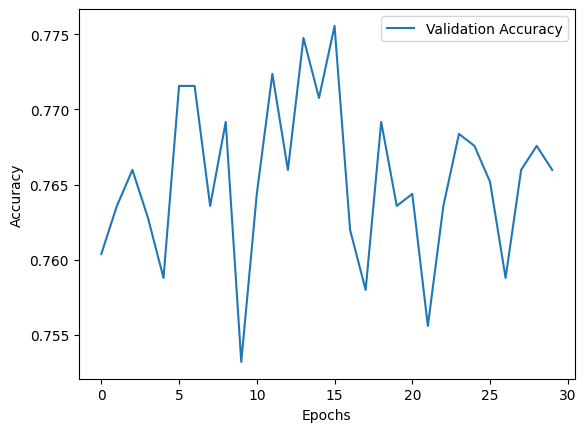

In [ ]:

def plot_accuracy_history(acc_history):
    val_acc = acc_history
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plot the accuracy history
plot_accuracy_history(acc_history)


The optimal amount of epochs seems to be around